[Reference](https://dining-developer.tistory.com/32)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = sm.datasets.macrodata.load_pandas().data
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
mydata = data[["realgdp", 'realdpi']]
mydata.index = data["year"]
mydata.head()

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


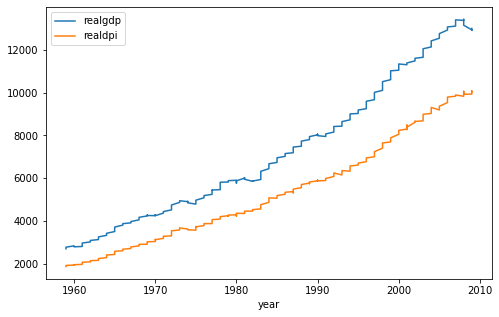

In [4]:
mydata.plot(figsize = (8,5))

# Stationary time series

- Non-Stationary Average - differencing
- Non-Stationary Variance - Transformation

In [5]:
adfuller_test = adfuller(mydata['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(mydata['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.7504627967647186
p-value: 0.9982455372335032
ADF test statistic: 2.9860253519546855
p-value: 1.0


In [6]:
mydata_diff = mydata.diff().dropna()

In [8]:
adfuller_test = adfuller(mydata_diff['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

adfuller_test = adfuller(mydata_diff['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658105
p-value: 3.327882187668224e-08
ADF test statistic: -8.864893340673007
p-value: 1.4493606159108096e-14


In [9]:
train = mydata_diff.iloc[:-10,:]
test = mydata_diff.iloc[-10:,:]

In [10]:
forecasting_model = VAR(train)
results_aic = []

for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


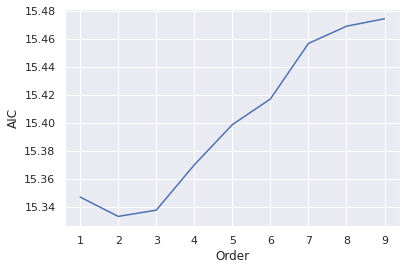

In [11]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [12]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Apr, 2021
Time:                     12:06:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

In [13]:
laaged_values = train.values[-2:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,61.872982,47.739232
2007.0,53.948996,41.742951
2007.0,56.171082,42.552316
2008.0,54.953081,42.023999
2008.0,55.109616,42.001007
2008.0,54.865410,41.937065
2008.0,54.841362,41.893996
2009.0,54.775171,41.878378
2009.0,54.754309,41.859837


In [14]:
forecast["realgdp_forecasted"] = mydata["realgdp"].iloc[-10-1] + forecast['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = mydata["realdpi"].iloc[-10-1] + forecast['realdpi_1d'].cumsum() 
forecast

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,61.872982,47.739232,13161.773982,9877.939232
2007.0,53.948996,41.742951,13215.722978,9919.682183
2007.0,56.171082,42.552316,13271.894060,9962.234500
2008.0,54.953081,42.023999,13326.847141,10004.258499
2008.0,55.109616,42.001007,13381.956757,10046.259506
2008.0,54.865410,41.937065,13436.822166,10088.196571
2008.0,54.841362,41.893996,13491.663528,10130.090566
2009.0,54.775171,41.878378,13546.438699,10171.968945
2009.0,54.754309,41.859837,13601.193008,10213.828781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


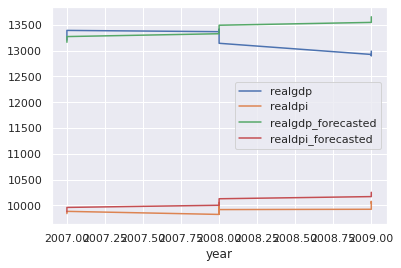

In [15]:
test = mydata.iloc[-10:,:]
test["realgdp_forecasted"] = forecast["realgdp_forecasted"]
test["realdpi_forecasted"] = forecast["realdpi_forecasted"]
test.plot()